In [1]:
import pandas as pd

typeg_data=pd.read_csv("./data/2330.TW.csv")

In [2]:
CA_rate=[typeg_data.iat[i,4]-typeg_data.iat[i,5] for i in range(len(typeg_data))]
typeg_data['CA_rate']=CA_rate
typeg_data

,Date,Open,High,Low,Close,Adj Close,Volume,CA_rate
0,2023-05-08,509.0,509.0,502.0,504.0,493.968842,11243634,10.031158
1,2023-05-09,507.0,510.0,505.0,510.0,499.849426,16197743,10.150574
2,2023-05-10,508.0,508.0,500.0,503.0,492.988739,18859212,10.011261
3,2023-05-11,506.0,506.0,498.5,499.0,489.068359,13382927,9.931641
4,2023-05-12,496.0,500.0,495.0,496.0,486.128113,18465362,9.871887
...,...,...,...,...,...,...,...,...
239,2024-04-30,797.0,802.0,790.0,790.0,790.000000,39051972,0.000000
240,2024-05-02,789.0,789.0,772.0,772.0,772.000000,40527228,0.000000
241,2024-05-03,788.0,788.0,773.0,780.0,780.000000,29901556,0.000000
242,2024-05-06,791.0,793.0,786.0,786.0,786.000000,32599878,0.000000


In [3]:
n=typeg_data.rename(columns={'Close':'clo'})

test_day=n.filter(['clo'])

test_day.shape[0]

244

In [4]:
test_day=test_day.reset_index(drop=True);test_day

,clo
0,504.0
1,510.0
2,503.0
3,499.0
4,496.0
...,...
239,790.0
240,772.0
241,780.0
242,786.0


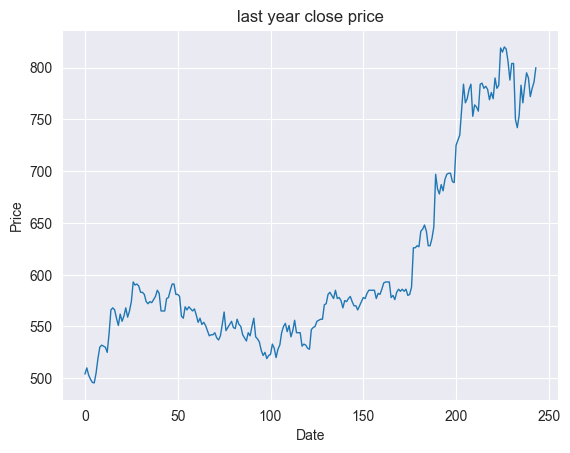

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
# plt.style.use("seaborn-darkgrid")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('last year close price')
# plt.plot(test_10day['High']-test_10day['clo'],linewidth=1)
plt.plot(test_day['clo'],linewidth=1)

plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
scaler_prices=scaler.fit_transform(test_day.values)

In [7]:
import numpy as  np
MOVING_WIN_SIZE=15

all_x,all_y=[],[]
for i in range(len(scaler_prices)-MOVING_WIN_SIZE):
    x=scaler_prices[i:i+MOVING_WIN_SIZE]
    y=scaler_prices[i+MOVING_WIN_SIZE]
    all_x.append(x)
    all_y.append(y)

all_x,all_y=np.array(all_x),np.array(all_y)

In [8]:
DS_SPLIT=0.8

train_ds_size=round(all_x.shape[0]*DS_SPLIT)
train_x,train_y=all_x[:train_ds_size],all_y[:train_ds_size]
test_x,test_y=all_x[train_ds_size:],all_y[train_ds_size:]

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model =Sequential()

model.add(LSTM(units=128,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=64,return_sequences=False))
model.add(Dense(units=2))
model.add(Dense(units=1))

# learning_rate = 0.01
# optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=25,
    decay_rate=0.99,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,loss="mean_squared_error")

model.summary()

c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,101 (453.52 KB)

 Trainable params: 116,101 (453.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

callback=EarlyStopping( monitor="val_loss",patience=100,restore_best_weights=True)
# callback=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00007)


model.fit(train_x,train_y,validation_split=0.2,callbacks=[callback],epochs=1000)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0234 - val_loss: 0.0051
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0310
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0357
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0153
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0148
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0253
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0235
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0172
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0163
Epoch 10/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0192
Epoch 11/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0178
Epoch 12/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


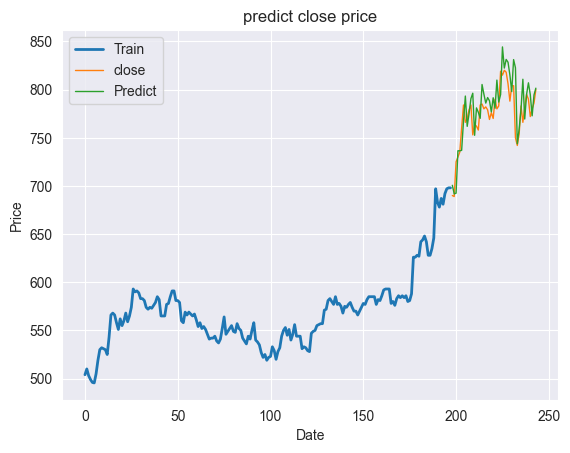

In [11]:
preds=model.predict(test_x)
preds=scaler.inverse_transform(preds)

train_data=test_day[:train_ds_size+MOVING_WIN_SIZE]
test_data=test_day[train_ds_size+MOVING_WIN_SIZE:]
test_data=test_data.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title('predict close price')
plt.plot(train_data['clo'],linewidth=2)
plt.plot(test_data['clo'],linewidth=1)
plt.plot(test_data['Predict'],linewidth=1)

plt.legend(["Train","close","Predict"])
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error

test_data=test_data.assign(Shifted=test_data['clo'].shift(1))
test_data.iat[0,-1]=train_data.iat[-1,-1]

predict_rmse=mean_squared_error(test_data['clo'],test_data['Predict'],squared=False)
predict_cvrmse=predict_rmse / test_data['clo'].mean()*100

shifted_rmse=mean_squared_error(test_data['clo'],test_data['Shifted'],squared=False)
shifted_cvrmse=shifted_rmse / test_data['clo'].mean()*100


print(f"predict\t=  {predict_cvrmse} % \nshift\t=  {shifted_cvrmse} %")

predict	=  2.726941163747983 % 
shift	=  2.1686312244831236 %


c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
